**integrantes**

Sharik Camila Rueda Lucero

Juan Camilo Molina Mussen

Daniel Gonzalez

Nicolas Cardona

In [ ]:
# Monta tu Drive
from google.colab import drive
drive.mount('/content/drive')

# Instala dependencias
!pip uninstall -y numpy opencv-python opencv-contrib-python opencv-python-headless mediapipe
!pip install numpy==1.26.4 mediapipe==0.10.20 pandas==2.2.2 matplotlib seaborn tqdm opencv-python-headless==4.9.0.80

Mounted at /content/drive
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 20.6 MB/s eta 0:0

In [ ]:
import os
import re
import cv2
import time
import math
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ruta base del proyecto
BASE_PATH = "/content/drive/MyDrive/APOIII/APOIII_Entrega1"

# Carpeta con los videos originales
VIDEOS_PATH = os.path.join(BASE_PATH, "videos")

# Carpeta de resultados
RESULTS_PATH = os.path.join(BASE_PATH, "resultados")

# Subcarpetas de resultados
POSE_DIR    = os.path.join(RESULTS_PATH, "videos_pose")   # videos procesados con pose
METRICS_DIR = os.path.join(RESULTS_PATH, "metrics")       # CSVs con métricas

# Crea las carpetas necesarias
os.makedirs(POSE_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print("Directorios configurados:")
print("BASE_PATH   :", BASE_PATH)
print("VIDEOS_PATH :", VIDEOS_PATH)
print("POSE_DIR    :", POSE_DIR)
print("METRICS_DIR :", METRICS_DIR)


Directorios configurados:
BASE_PATH   : /content/drive/MyDrive/APOIII/APOIII_Entrega1
VIDEOS_PATH : /content/drive/MyDrive/APOIII/APOIII_Entrega1/videos
POSE_DIR    : /content/drive/MyDrive/APOIII/APOIII_Entrega1/resultados/videos_pose
METRICS_DIR : /content/drive/MyDrive/APOIII/APOIII_Entrega1/resultados/metrics


In [ ]:


# Configuración de MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

POSE = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,          # 0,1,2 -> 1 equilibrio latencia/precisión
    enable_segmentation=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Índices de landmarks (33 puntos)
LHIP  = mp_pose.PoseLandmark.LEFT_HIP.value
RHIP  = mp_pose.PoseLandmark.RIGHT_HIP.value
LSHO  = mp_pose.PoseLandmark.LEFT_SHOULDER.value
RSHO  = mp_pose.PoseLandmark.RIGHT_SHOULDER.value
LKNE  = mp_pose.PoseLandmark.LEFT_KNEE.value
RKNE  = mp_pose.PoseLandmark.RIGHT_KNEE.value
LANK  = mp_pose.PoseLandmark.LEFT_ANKLE.value
RANK  = mp_pose.PoseLandmark.RIGHT_ANKLE.value


In [ ]:
def angle_between(p_a, p_b, p_c):
    """
    Ángulo ABC (en grados) con vértice en B.
    p_* son tuplas (x, y) en píxeles.
    """
    a, b, c = map(lambda p: np.array(p, dtype=float), (p_a, p_b, p_c))
    v1, v2 = a - b, c - b
    denom = (np.linalg.norm(v1) * np.linalg.norm(v2))
    if denom == 0:
        return np.nan
    cosang = np.clip(np.dot(v1, v2) / denom, -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def hip_center(landmarks_px):
    """Centro de cadera (promedio de cadera izq/der) en píxeles."""
    lh, rh = landmarks_px[LHIP], landmarks_px[RHIP]
    return ((lh[0] + rh[0]) / 2.0, (lh[1] + rh[1]) / 2.0)

def shoulder_inclination(landmarks_px):
    """
    Inclinación promedio de hombros (diferencia vertical, en píxeles).
    Positivo si el hombro derecho está más abajo que el izquierdo.
    """
    lsh, rsh = landmarks_px[LSHO], landmarks_px[RSHO]
    return rsh[1] - lsh[1]

def average_knee_angle(landmarks_px):
    """
    Ángulo promedio de rodillas (en grados) combinando izquierda y derecha.
    """
    lk = angle_between(landmarks_px[LHIP], landmarks_px[LKNE], landmarks_px[LANK])
    rk = angle_between(landmarks_px[RHIP], landmarks_px[RKNE], landmarks_px[RANK])
    return np.nanmean([lk, rk])

def avg_frame_brightness(frame_bgr):
    """Brillo promedio (0-255) del frame en escala de grises."""
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    return float(np.mean(gray))

def interframe_displacement(prev_points, curr_points, use_subset=True):
    """
    Movimiento promedio: distancia euclídea entre frames consecutivos
    (promedio sobre un subconjunto estable de landmarks).
    """
    if prev_points is None or curr_points is None:
        return np.nan
    idxs = [LSHO, RSHO, LHIP, RHIP, LKNE, RKNE, LANK, RANK] if use_subset else range(len(curr_points))
    dists = []
    for i in idxs:
        p, q = prev_points[i], curr_points[i]
        if p is None or q is None:
            continue
        dists.append(math.dist(p, q))
    return float(np.mean(dists)) if dists else np.nan


In [ ]:
# === Mapeo de acción desde el nombre del archivo (ajustado a tus videos) ===
# Canonicalizamos a estas etiquetas:
#   caminar_hacia_adelante, caminar_atras,
#   caminar_derecha, caminar_izquierda,
#   pararse, sentarse,
#   vuelta_derecha, vuelta_izquierda

ACTION_PATTERNS = {
    # Caminar frontal
    "caminar_hacia_adelante":  r"(?:^|[_\- ])caminar(?:[_\- ])hacia(?:[_\- ])adelante(?:$|\.)",

    # Caminar atrás
    "caminar_atras":           r"(?:^|[_\- ])caminar(?:[_\- ])atras(?:$|\.)",

    # Caminar derecha (incluye 'caminar_de_lado_hacia_la_derecha' y 'caminar_derecha')
    "caminar_derecha":         r"(?:^|[_\- ])caminar(?:(?:[_\- ])de(?:[_\- ])lado(?:[_\- ])hacia(?:[_\- ])la)?(?:[_\- ])derecha(?:$|\.)",

    # Caminar izquierda (incluye 'caminar_de_lado_hacia_la_izquierda' y 'caminar_izquierda')
    "caminar_izquierda":       r"(?:^|[_\- ])caminar(?:(?:[_\- ])de(?:[_\- ])lado(?:[_\- ])hacia(?:[_\- ])la)?(?:[_\- ])izquierda(?:$|\.)",

    # Acciones estáticas
    "pararse":                 r"(?:^|[_\- ])pararse(?:$|\.)",
    "sentarse":                r"(?:^|[_\- ])sentarse(?:$|\.)",

    # Giros / vueltas
    "vuelta_derecha":          r"(?:^|[_\- ])(?:vuelta|giro)(?:[_\- ])derecha(?:$|\.)",
    "vuelta_izquierda":        r"(?:^|[_\- ])(?:vuelta|giro)(?:[_\- ])izquierda(?:$|\.)",
}

def infer_action_from_filename(fname: str) -> str:
    """
    Devuelve la etiqueta canónica de acción con base en el nombre del archivo.
    Es robusto a espacios/guiones/guiones bajos. Si no matchea, devuelve 'desconocida'.
    """
    base = os.path.basename(fname).lower()
    base = base.replace(" ", "_")  # normalizamos espacios a _
    for action, pattern in ACTION_PATTERNS.items():
        if re.search(pattern, base):
            return action
    return "desconocida"


In [ ]:
def landmarks_to_pixel_list(landmarks, width, height, min_visibility=0.5):
    """
    Convierte landmarks normalizados a (x_px, y_px) o None si visibilidad baja.
    """
    pts = []
    for lm in landmarks:
        x_px = int(lm.x * width)
        y_px = int(lm.y * height)
        if lm.visibility is not None and lm.visibility < min_visibility:
            pts.append(None)
        else:
            pts.append((x_px, y_px))
    return pts


In [ ]:
def process_video(in_path, out_path, collect_frames=False):
    """
    - Lee el video de entrada.
    - Ejecuta MediaPipe Pose.
    - Dibuja el esqueleto y overlay de métricas.
    - Guarda un nuevo video en out_path.
    - Devuelve: resumen por video y (opcional) DataFrame por frame.
    """
    cap = cv2.VideoCapture(in_path)
    if not cap.isOpened():
        print(f"[WARN] No se pudo abrir: {in_path}")
        return None, None

    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
    w   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    nfr = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

    hip_speeds, incl_shoulders, knee_angles, movements, brightness = [], [], [], [], []
    frames_records = [] if collect_frames else None

    prev_hip_center = None
    prev_pts = None
    frame_idx = 0

    pbar = tqdm(total=nfr if nfr>0 else None, desc=os.path.basename(in_path), leave=False)
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = POSE.process(frame_rgb)

        curr_pts, hc = None, None
        sh_inc, knee = np.nan, np.nan

        if res.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame,
                res.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=2)
            )
            curr_pts = landmarks_to_pixel_list(res.pose_landmarks.landmark, w, h, min_visibility=0.5)
            try:    hc    = hip_center(curr_pts)
            except: hc    = None
            try:    sh_inc = shoulder_inclination(curr_pts)
            except: sh_inc = np.nan
            try:    knee   = average_knee_angle(curr_pts)
            except: knee   = np.nan

        hip_speed = np.nan
        if hc is not None and prev_hip_center is not None:
            hip_speed = math.dist(hc, prev_hip_center)

        move_avg  = interframe_displacement(prev_pts, curr_pts, use_subset=True)
        bri       = avg_frame_brightness(frame)

        hip_speeds.append(hip_speed)
        incl_shoulders.append(sh_inc)
        knee_angles.append(knee)
        movements.append(move_avg)
        brightness.append(bri)

        # Overlay simple
        overlay = f"hip_v(px/f): {hip_speed:5.1f} | sh_tilt(px): {sh_inc:6.1f} | knee(deg): {knee:6.1f}"
        cv2.rectangle(frame, (10,10), (10+630, 10+30), (0,0,0), thickness=-1)
        cv2.putText(frame, overlay, (18,32), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,255), 2, cv2.LINE_AA)

        out.write(frame)

        if collect_frames:
            frames_records.append({
                "video": os.path.basename(in_path),
                "frame": frame_idx,
                "hip_speed_px_per_frame": hip_speed,
                "shoulder_tilt_px": sh_inc,
                "knee_angle_deg": knee,
                "movement_avg_px": move_avg,
                "brightness": bri
            })

        prev_hip_center = hc
        prev_pts = curr_pts
        frame_idx += 1
        pbar.update(1)
    pbar.close()

    cap.release()
    out.release()

    duration_s = frame_idx / fps if fps > 0 else np.nan
    summary = {
        "video": os.path.basename(in_path),
        "frames": frame_idx,
        "fps": fps,
        "duration_s": duration_s,
        "brightness_avg": np.nanmean(brightness),
        "hip_speed_avg_px_per_frame": np.nanmean(hip_speeds),
        "shoulder_tilt_avg_px": np.nanmean(incl_shoulders),
        "knee_angle_avg_deg": np.nanmean(knee_angles),
        "movement_avg_px": np.nanmean(movements),
    }

    df_frames = pd.DataFrame(frames_records) if collect_frames else None
    return summary, df_frames


In [ ]:
# Listar videos en VIDEOS_PATH (mp4, mov, avi, mkv)
videos = [os.path.join(VIDEOS_PATH, f)
          for f in os.listdir(VIDEOS_PATH)
          if f.lower().endswith((".mp4", ".mov", ".avi", ".mkv"))]

if not videos:
    print("⚠️ No se encontraron videos en:", VIDEOS_PATH)

summaries = []
frames_all = []

for v in videos:
    action = infer_action_from_filename(v)
    out_name = f"{os.path.splitext(os.path.basename(v))[0]}__pose.mp4"
    out_path = os.path.join(POSE_DIR, out_name)

    summary, df_frames = process_video(v, out_path, collect_frames=False)  # pon True si quieres CSV por frame

    if summary:
        summary["action"] = action
        summaries.append(summary)
    if df_frames is not None and not df_frames.empty:
        df_frames["action"] = action
        frames_all.append(df_frames)

# Guardar CSVs en Drive
df_summary = pd.DataFrame(summaries).sort_values(by="video")
summary_csv = os.path.join(METRICS_DIR, "metrics_por_video.csv")
df_summary.to_csv(summary_csv, index=False)

if frames_all:
    df_frames_all = pd.concat(frames_all, ignore_index=True)
    frames_csv = os.path.join(METRICS_DIR, "frames_detalle.csv")
    df_frames_all.to_csv(frames_csv, index=False)

print("CSV de métricas por video guardado en:", summary_csv)
if frames_all:
    print("CSV de detalle por frame guardado en:", frames_csv)

df_summary


✅ CSV de métricas por video guardado en: /content/drive/MyDrive/APOIII/APOIII_Entrega1/resultados/metrics/metrics_por_video.csv


,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
3,caminar_atras.mp4,175,30.023619,5.828744,148.149862,1.878040,2.034483,174.056788,2.015396,caminar_atras
1,caminar_de_lado_hacia_la_derecha.mp4,197,30.025148,6.561167,156.489401,1.878821,-1.275510,174.622530,1.987462,caminar_derecha
2,caminar_de_lado_hacia_la_izquierda.mp4,218,30.028100,7.259867,155.445640,1.724559,-1.408257,174.667098,1.858479,caminar_izquierda
4,caminar_derecha.mp4,139,30.024336,4.629578,156.455026,2.913625,-7.644928,163.415127,3.839454,caminar_derecha
0,caminar_hacia_adelante.mp4,208,30.033595,6.925578,159.211040,1.252136,-0.129808,173.633066,3.772867,caminar_hacia_adelante
5,caminar_izquierda.mp4,179,30.027679,5.961167,155.451308,2.471418,8.759777,163.783652,2.979586,caminar_izquierda
6,pararse.mp4,147,30.028735,4.895311,156.103369,0.911448,-2.205479,149.830301,0.655097,pararse
7,sentarse.mp4,145,30.024641,4.829367,155.786795,0.812322,-2.896552,112.686479,0.710073,sentarse
8,vuelta_derecha.mp4,153,30.025381,5.095689,157.957709,1.270706,-2.581699,169.952405,1.685610,vuelta_derecha
9,vuelta_izquierda.mp4,172,30.025894,5.728389,158.362210,0.905934,-1.127907,170.912746,1.319330,vuelta_izquierda


,video,frames,fps,duration_s,brightness_avg,hip_speed_avg_px_per_frame,shoulder_tilt_avg_px,knee_angle_avg_deg,movement_avg_px,action
0,caminar_atras.mp4,175,30.023619,5.828744,148.149862,1.878040,2.034483,174.056788,2.015396,caminar_atras
1,caminar_de_lado_hacia_la_derecha.mp4,197,30.025148,6.561167,156.489401,1.878821,-1.275510,174.622530,1.987462,caminar_derecha
2,caminar_de_lado_hacia_la_izquierda.mp4,218,30.028100,7.259867,155.445640,1.724559,-1.408257,174.667098,1.858479,caminar_izquierda
3,caminar_derecha.mp4,139,30.024336,4.629578,156.455026,2.913625,-7.644928,163.415127,3.839454,caminar_derecha
4,caminar_hacia_adelante.mp4,208,30.033595,6.925578,159.211040,1.252136,-0.129808,173.633066,3.772867,caminar_hacia_adelante


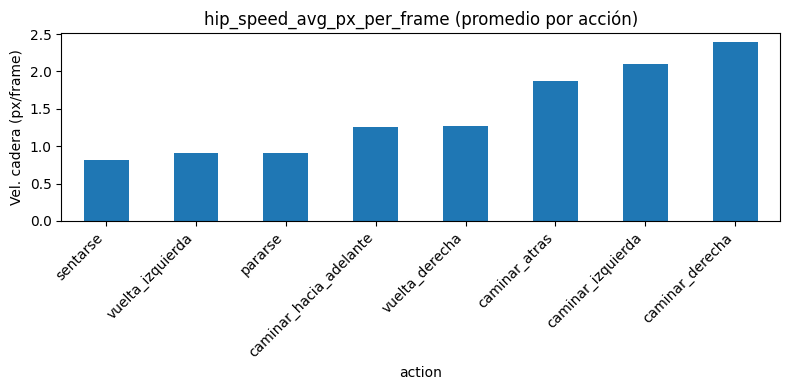

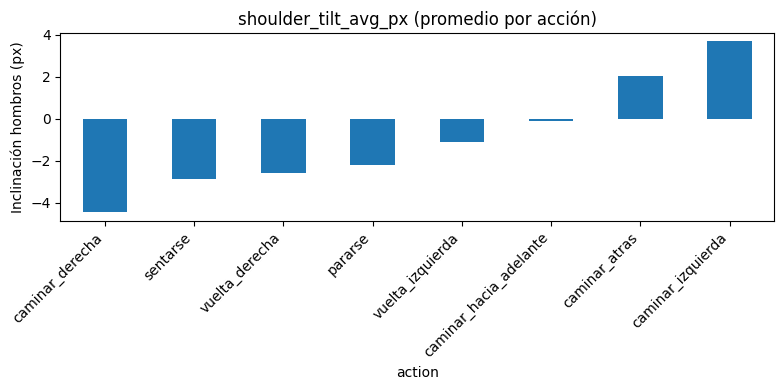

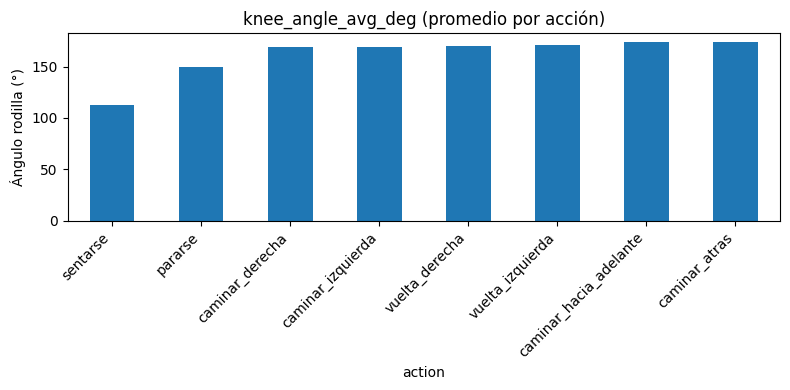

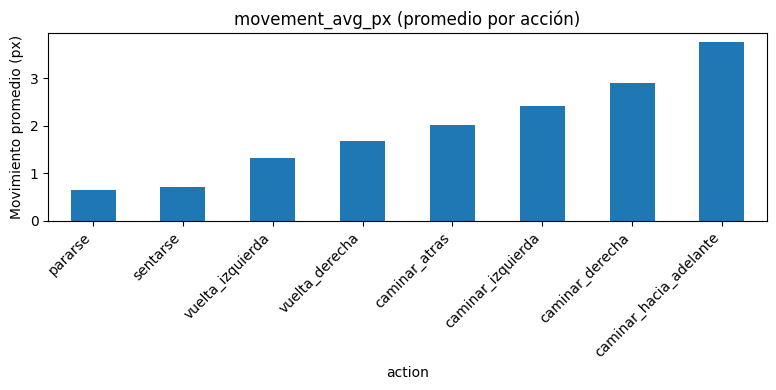

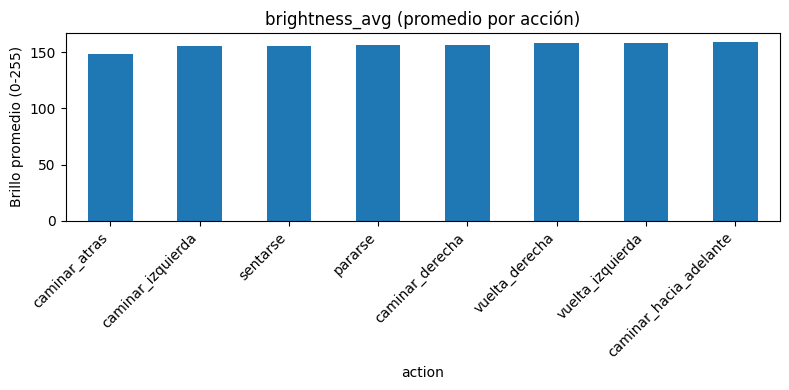

In [ ]:
# Cargar el resumen
summary_path = os.path.join(METRICS_DIR, "metrics_por_video.csv")
eda = pd.read_csv(summary_path)
display(eda.head())

def bar_metric_by_action(df, metric, ylabel):
    means = df.groupby("action")[metric].mean().sort_values()
    plt.figure(figsize=(8,4))
    means.plot(kind="bar")
    plt.ylabel(ylabel)
    plt.title(f"{metric} (promedio por acción)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

bar_metric_by_action(eda, "hip_speed_avg_px_per_frame", "Vel. cadera (px/frame)")
bar_metric_by_action(eda, "shoulder_tilt_avg_px", "Inclinación hombros (px)")
bar_metric_by_action(eda, "knee_angle_avg_deg", "Ángulo rodilla (°)")
bar_metric_by_action(eda, "movement_avg_px", "Movimiento promedio (px)")
bar_metric_by_action(eda, "brightness_avg", "Brillo promedio (0-255)")


##**Conclusiones con base en los resultados obtenidos**

**Relevancia de la velocidad de la cadera y el movimiento promedio**

La velocidad promedio de la cadera y el movimiento promedio entre fotogramas resultaron ser las métricas más representativas y determinantes para distinguir entre las diferentes actividades analizadas. En las acciones de caminar ya sea hacia adelante, atrás o en desplazamientos laterales, los valores de ambas métricas fueron considerablemente más altos, reflejando un movimiento corporal continuo y sostenido. En contraste, las acciones estáticas o transicionales, como sentarse o pararse, registraron valores mucho más bajos, lo que indica un desplazamiento limitado o casi nulo del cuerpo. Esta clara separación demuestra que estas dos métricas capturan de manera efectiva el nivel de dinamismo y desplazamiento corporal, por lo que serán variables fundamentales para entrenar el modelo de clasificación.

**Importancia del ángulo promedio de la rodilla**

El ángulo promedio de la rodilla desempeña un papel esencial en la caracterización de las posturas y en la identificación de las fases del movimiento. Se observó que los valores de esta métrica son significativamente menores en actividades donde el sujeto realiza flexiones, como al sentarse o levantarse, mientras que tienden a ser más amplios en acciones que implican caminar o girar, donde las piernas permanecen relativamente extendidas. Este patrón demuestra que el ángulo de la rodilla actúa como un indicador biomecánico de la postura, permitiendo reconocer con precisión si el movimiento pertenece a una fase de flexión o extensión.


**Inclinación de los hombros como indicador direccional**

La inclinación promedio de los hombros aporta una dimensión adicional al análisis, ya que refleja la orientación del cuerpo y la dirección del movimiento. Los resultados evidencian que cuando el individuo camina hacia la izquierda, la inclinación de los hombros es positiva, mientras que al caminar hacia la derecha la inclinación se torna negativa. Esto sugiere que el ángulo entre los hombros no solo depende de la postura, sino también del sentido del desplazamiento y del balance corporal durante el movimiento. Por tanto, esta métrica se convierte en un indicador direccional clave, capaz de diferenciar no solo entre moverse o permanecer quieto, sino también entre los distintos sentidos de desplazamiento.

**Estabilidad técnica y calidad de los datos**

Los valores registrados en el brillo promedio y los fotogramas por segundo (FPS) fueron consistentes en todos los videos, lo que indica que las condiciones de grabación se mantuvieron estables y que las diferencias observadas entre acciones provienen del comportamiento corporal y no de factores externos. Esta uniformidad en la calidad de los datos garantiza que las métricas biomecánicas extraídas sean confiables y comparables entre sí. La estabilidad técnica obtenida respalda la validez de los resultados y asegura que las conclusiones extraídas reflejan fielmente el desempeño físico de las personas y no alteraciones debidas a la iluminación o la captura.